In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
#from sklearn.model_selection import train_test_split

In [2]:
##### 測試用資料集 #####

#import pathlib

#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
#data_dir = pathlib.Path(data_dir)

In [3]:
train_dir = "C:/Users/user/Pictures/nuk"

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=8,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=0,
    interpolation="bilinear",
    follow_links=False,
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=8,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=0,
    interpolation="bilinear",
    follow_links=False,
)

# 正規化

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), tf.cast(y, dtype=tf.int32)))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), tf.cast(y, dtype=tf.int32)))


Found 24755 files belonging to 3 classes.
Using 19804 files for training.
Found 24755 files belonging to 3 classes.
Using 4951 files for validation.


In [5]:

def create_model():
    net = InceptionV3(include_top=False, weights='imagenet', input_tensor=None,
                      input_shape=(224, 224, 3)
                      )
    l2 = tf.keras.regularizers.l2(0.01)

    # 透過layer_name 節取 model的某一層 例如： block3_pool block4_conv3
    layer_name = 'mixed10'

    # 設定取到該層的都使用預設參數，不訓練參數
    layer_index = net.layers.index(net.get_layer(layer_name))

    # 建立模型
    base_model = net.get_layer(layer_name).output

    # 攤平 feature map
    base_model = layers.Flatten()(base_model)

    # units = 128(隨意調整) Dropout(0.9(隨意調整))
    base_model = layers.Dropout(0.2)(base_model)
    base_model = layers.BatchNormalization()(base_model)
    base_model = layers.Dense(units=128, kernel_initializer=tf.keras.initializers.GlorotNormal()
                              , kernel_regularizer=l2, activation='relu')(base_model)
    base_model = layers.Dense(units=128, kernel_initializer=tf.keras.initializers.GlorotNormal()
                              , kernel_regularizer=l2, activation='relu')(base_model)

    base_model = layers.Dropout(0.3)(base_model)
    
    #記得改units(分類數)
    output_layer = layers.Dense(units=3, activation='softmax', name='softmax')(base_model)
    
    # 組合模型
    net_final = tf.keras.models.Model(inputs=net.input, outputs=output_layer)
    
    # 設定凍結與要進行訓練的網路層
    for layer in net_final.layers[:layer_index]:
        layer.trainable = False
    return net_final

In [6]:
test_model = create_model()
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [7]:
# EarlyStopping
# monitor='val_accuracy',mode='max', patience=5 ,restore_best_weights=True提前停止連續patience次績效沒更好就停止
modelpath = "{}/../model_nuk"
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True
    ),
    
    # ModelCheckpoint存模型根據monitor='val_accuracy'處存('val_accuracy')mode='max'最大績效('max')()可更改
    tf.keras.callbacks.ModelCheckpoint(
        filepath= modelpath.format(train_dir),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
    ),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                         patience=3,
                                         # 3 epochs 內acc沒下降就要調整LR
                                         verbose=1,
                                         factor=0.5,
                                         # LR降為0.5
                                         mode='max',
                                         min_lr=0.000005
                                         # 最小 LR 到0.000005就不再下降
                                         )]

metrics_list = [
    tf.keras.metrics.CategoricalCrossentropy(name='loss'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.FalseNegatives(name='FalseNegatives'),
    tf.keras.metrics.FalsePositives(name='FalsePositives'),
    tf.keras.metrics.TrueNegatives(name='TrueNegatives'),
    tf.keras.metrics.TruePositives(name='TruePositives'),
]

adam = tf.keras.optimizers.Adam(learning_rate=0.001)  # 學習率0.001
model_loss = tf.keras.losses.CategoricalCrossentropy()
test_model.compile(optimizer=adam,
                   loss=model_loss,
                   metrics=metrics_list)

In [8]:
history = test_model.fit(train_dataset,
                         validation_data=val_dataset,
                         epochs=50,
                         callbacks=callbacks_list
                         )

Epoch 1/50
2476/2476 [==============================] - ETA: 0s - loss: 0.1843 - precision: 0.9703 - recall: 0.9691 - accuracy: 0.9698 - FalseNegatives: 611.0000 - FalsePositives: 588.0000 - TrueNegatives: 39020.0000 - TruePositives: 19193.0000

INFO:tensorflow:Assets written to: C:/Users/user/Pictures/nuk/..\model_nuk\assets


INFO:tensorflow:Assets written to: C:/Users/user/Pictures/nuk/..\model_nuk\assets


2476/2476 [==============================] - 92s 34ms/step - loss: 0.1843 - precision: 0.9703 - recall: 0.9691 - accuracy: 0.9698 - FalseNegatives: 611.0000 - FalsePositives: 588.0000 - TrueNegatives: 39020.0000 - TruePositives: 19193.0000 - val_loss: 0.0590 - val_precision: 0.9844 - val_recall: 0.9842 - val_accuracy: 0.9842 - val_FalseNegatives: 78.0000 - val_FalsePositives: 77.0000 - val_TrueNegatives: 9825.0000 - val_TruePositives: 4873.0000 - lr: 0.0010
Epoch 2/50
2475/2476 [============================>.] - ETA: 0s - loss: 0.0719 - precision: 0.9782 - recall: 0.9755 - accuracy: 0.9766 - FalseNegatives: 486.0000 - FalsePositives: 431.0000 - TrueNegatives: 39169.0000 - TruePositives: 19314.0000

INFO:tensorflow:Assets written to: C:/Users/user/Pictures/nuk/..\model_nuk\assets


INFO:tensorflow:Assets written to: C:/Users/user/Pictures/nuk/..\model_nuk\assets


2476/2476 [==============================] - 89s 36ms/step - loss: 0.0719 - precision: 0.9782 - recall: 0.9755 - accuracy: 0.9766 - FalseNegatives: 486.0000 - FalsePositives: 431.0000 - TrueNegatives: 39177.0000 - TruePositives: 19318.0000 - val_loss: 0.0055 - val_precision: 0.9976 - val_recall: 0.9976 - val_accuracy: 0.9976 - val_FalseNegatives: 12.0000 - val_FalsePositives: 12.0000 - val_TrueNegatives: 9890.0000 - val_TruePositives: 4939.0000 - lr: 0.0010
Epoch 3/50
2476/2476 [==============================] - 74s 30ms/step - loss: 0.0708 - precision: 0.9809 - recall: 0.9784 - accuracy: 0.9795 - FalseNegatives: 428.0000 - FalsePositives: 377.0000 - TrueNegatives: 39231.0000 - TruePositives: 19376.0000 - val_loss: 0.0104 - val_precision: 0.9964 - val_recall: 0.9964 - val_accuracy: 0.9964 - val_FalseNegatives: 18.0000 - val_FalsePositives: 18.0000 - val_TrueNegatives: 9884.0000 - val_TruePositives: 4933.0000 - lr: 0.0010
Epoch 4/50
2476/2476 [==============================] - 75s 30ms/

INFO:tensorflow:Assets written to: C:/Users/user/Pictures/nuk/..\model_nuk\assets


INFO:tensorflow:Assets written to: C:/Users/user/Pictures/nuk/..\model_nuk\assets


2476/2476 [==============================] - 90s 36ms/step - loss: 0.0504 - precision: 0.9849 - recall: 0.9824 - accuracy: 0.9835 - FalseNegatives: 348.0000 - FalsePositives: 299.0000 - TrueNegatives: 39309.0000 - TruePositives: 19456.0000 - val_loss: 0.0055 - val_precision: 0.9996 - val_recall: 0.9984 - val_accuracy: 0.9992 - val_FalseNegatives: 8.0000 - val_FalsePositives: 2.0000 - val_TrueNegatives: 9900.0000 - val_TruePositives: 4943.0000 - lr: 0.0010
Epoch 6/50
2476/2476 [==============================] - 75s 30ms/step - loss: 0.0509 - precision: 0.9840 - recall: 0.9818 - accuracy: 0.9830 - FalseNegatives: 360.0000 - FalsePositives: 317.0000 - TrueNegatives: 39291.0000 - TruePositives: 19444.0000 - val_loss: 0.0085 - val_precision: 0.9978 - val_recall: 0.9976 - val_accuracy: 0.9978 - val_FalseNegatives: 12.0000 - val_FalsePositives: 11.0000 - val_TrueNegatives: 9891.0000 - val_TruePositives: 4939.0000 - lr: 0.0010
Epoch 7/50
2476/2476 [==============================] - 75s 30ms/st

INFO:tensorflow:Assets written to: C:/Users/user/Pictures/nuk/..\model_nuk\assets


INFO:tensorflow:Assets written to: C:/Users/user/Pictures/nuk/..\model_nuk\assets


2476/2476 [==============================] - 90s 36ms/step - loss: 0.0479 - precision: 0.9856 - recall: 0.9835 - accuracy: 0.9846 - FalseNegatives: 326.0000 - FalsePositives: 284.0000 - TrueNegatives: 39324.0000 - TruePositives: 19478.0000 - val_loss: 0.0025 - val_precision: 0.9994 - val_recall: 0.9994 - val_accuracy: 0.9994 - val_FalseNegatives: 3.0000 - val_FalsePositives: 3.0000 - val_TrueNegatives: 9899.0000 - val_TruePositives: 4948.0000 - lr: 0.0010
Epoch 9/50
2476/2476 [==============================] - 73s 29ms/step - loss: 0.0437 - precision: 0.9868 - recall: 0.9854 - accuracy: 0.9862 - FalseNegatives: 290.0000 - FalsePositives: 262.0000 - TrueNegatives: 39346.0000 - TruePositives: 19514.0000 - val_loss: 0.0081 - val_precision: 0.9982 - val_recall: 0.9972 - val_accuracy: 0.9980 - val_FalseNegatives: 14.0000 - val_FalsePositives: 9.0000 - val_TrueNegatives: 9893.0000 - val_TruePositives: 4937.0000 - lr: 0.0010
Epoch 10/50
2476/2476 [==============================] - 70s 28ms/st

INFO:tensorflow:Assets written to: C:/Users/user/Pictures/nuk/..\model_nuk\assets


INFO:tensorflow:Assets written to: C:/Users/user/Pictures/nuk/..\model_nuk\assets


2476/2476 [==============================] - 83s 34ms/step - loss: 0.0462 - precision: 0.9857 - recall: 0.9841 - accuracy: 0.9849 - FalseNegatives: 314.0000 - FalsePositives: 282.0000 - TrueNegatives: 39326.0000 - TruePositives: 19490.0000 - val_loss: 0.0011 - val_precision: 0.9998 - val_recall: 0.9998 - val_accuracy: 0.9998 - val_FalseNegatives: 1.0000 - val_FalsePositives: 1.0000 - val_TrueNegatives: 9901.0000 - val_TruePositives: 4950.0000 - lr: 0.0010
Epoch 12/50
2476/2476 [==============================] - 70s 28ms/step - loss: 0.0398 - precision: 0.9879 - recall: 0.9862 - accuracy: 0.9868 - FalseNegatives: 274.0000 - FalsePositives: 240.0000 - TrueNegatives: 39368.0000 - TruePositives: 19530.0000 - val_loss: 0.0025 - val_precision: 0.9994 - val_recall: 0.9992 - val_accuracy: 0.9992 - val_FalseNegatives: 4.0000 - val_FalsePositives: 3.0000 - val_TrueNegatives: 9899.0000 - val_TruePositives: 4947.0000 - lr: 0.0010
Epoch 13/50
2476/2476 [==============================] - 70s 28ms/st

INFO:tensorflow:Assets written to: C:/Users/user/Pictures/nuk/..\model_nuk\assets


INFO:tensorflow:Assets written to: C:/Users/user/Pictures/nuk/..\model_nuk\assets


2476/2476 [==============================] - 83s 34ms/step - loss: 0.0243 - precision: 0.9925 - recall: 0.9918 - accuracy: 0.9921 - FalseNegatives: 162.0000 - FalsePositives: 148.0000 - TrueNegatives: 39460.0000 - TruePositives: 19642.0000 - val_loss: 2.3374e-04 - val_precision: 1.0000 - val_recall: 1.0000 - val_accuracy: 1.0000 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 0.0000e+00 - val_TrueNegatives: 9902.0000 - val_TruePositives: 4951.0000 - lr: 5.0000e-04
Epoch 16/50
2476/2476 [==============================] - 74s 30ms/step - loss: 0.0246 - precision: 0.9927 - recall: 0.9915 - accuracy: 0.9921 - FalseNegatives: 168.0000 - FalsePositives: 144.0000 - TrueNegatives: 39464.0000 - TruePositives: 19636.0000 - val_loss: 2.5659e-04 - val_precision: 1.0000 - val_recall: 1.0000 - val_accuracy: 1.0000 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 0.0000e+00 - val_TrueNegatives: 9902.0000 - val_TruePositives: 4951.0000 - lr: 5.0000e-04
Epoch 17/50
2476/2476 [=============

2476/2476 [==============================] - 82s 33ms/step - loss: 0.0048 - precision: 0.9988 - recall: 0.9987 - accuracy: 0.9988 - FalseNegatives: 26.0000 - FalsePositives: 24.0000 - TrueNegatives: 39584.0000 - TruePositives: 19778.0000 - val_loss: 7.5133e-05 - val_precision: 1.0000 - val_recall: 1.0000 - val_accuracy: 1.0000 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 0.0000e+00 - val_TrueNegatives: 9902.0000 - val_TruePositives: 4951.0000 - lr: 3.1250e-05
Epoch 30/50
2475/2476 [============================>.] - ETA: 0s - loss: 0.0047 - precision: 0.9991 - recall: 0.9986 - accuracy: 0.9990 - FalseNegatives: 27.0000 - FalsePositives: 17.0000 - TrueNegatives: 39583.0000 - TruePositives: 19773.0000
Epoch 30: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
2476/2476 [==============================] - 82s 33ms/step - loss: 0.0047 - precision: 0.9991 - recall: 0.9986 - accuracy: 0.9990 - FalseNegatives: 27.0000 - FalsePositives: 17.0000 - TrueNegatives: 39591

2476/2476 [==============================] - 82s 33ms/step - loss: 0.0032 - precision: 0.9996 - recall: 0.9995 - accuracy: 0.9995 - FalseNegatives: 10.0000 - FalsePositives: 7.0000 - TrueNegatives: 39601.0000 - TruePositives: 19794.0000 - val_loss: 4.7232e-05 - val_precision: 1.0000 - val_recall: 1.0000 - val_accuracy: 1.0000 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 0.0000e+00 - val_TrueNegatives: 9902.0000 - val_TruePositives: 4951.0000 - lr: 5.0000e-06
Epoch 45/50
2476/2476 [==============================] - 83s 33ms/step - loss: 0.0030 - precision: 0.9996 - recall: 0.9995 - accuracy: 0.9996 - FalseNegatives: 9.0000 - FalsePositives: 8.0000 - TrueNegatives: 39600.0000 - TruePositives: 19795.0000 - val_loss: 4.4789e-05 - val_precision: 1.0000 - val_recall: 1.0000 - val_accuracy: 1.0000 - val_FalseNegatives: 0.0000e+00 - val_FalsePositives: 0.0000e+00 - val_TrueNegatives: 9902.0000 - val_TruePositives: 4951.0000 - lr: 5.0000e-06
Epoch 46/50
2476/2476 [====================

<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\user\AppData\Local\Temp\ipykernel_19848\3373205860.py:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if 'loss' is history_key1:


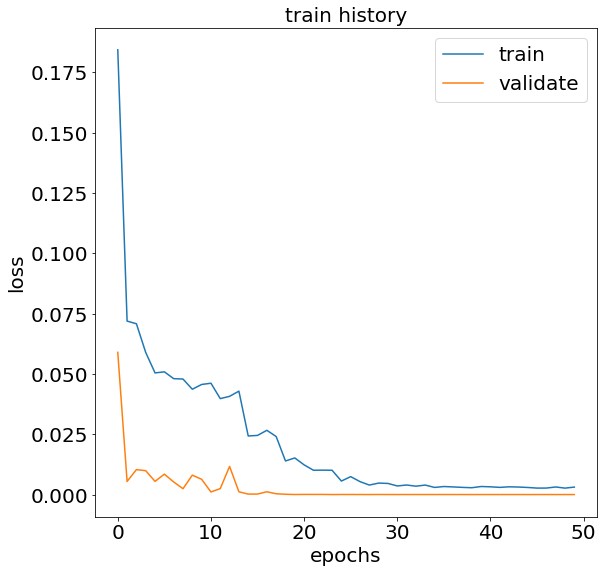

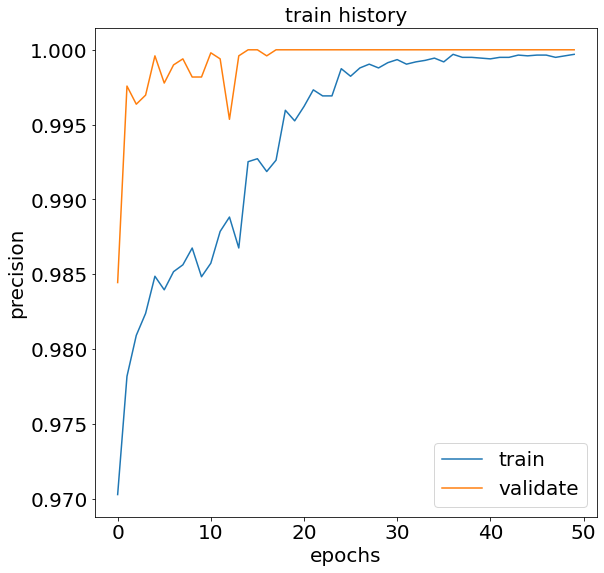

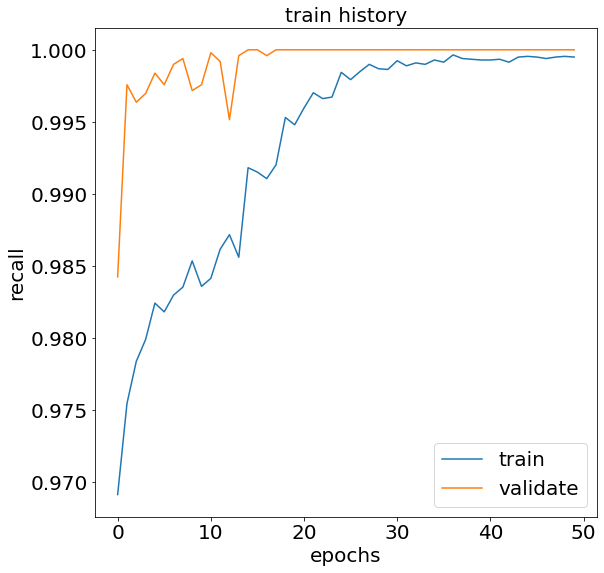

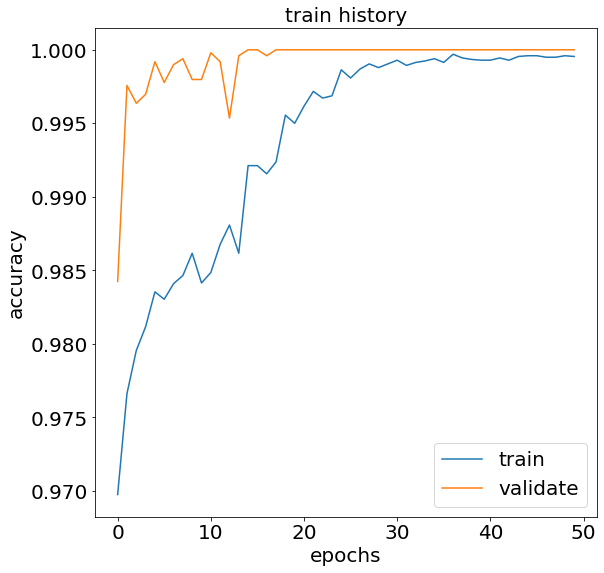

In [9]:

def train_history_graphic(history  # 資料集合
                          , history_key1  # 資料集合裡面的來源 1 (有 loss, acc, val_loss, val_acc 四種)
                          , history_key2  # 資料集合裡面的來源 2 (有 loss, acc, val_loss, val_acc 四種)
                          , y_label  # Y 軸標籤文字
                          , index=0
                          ):
    plt.figure(figsize=(9, 9))
    font_size = 20
    # 資料來源 1
    plt.plot(history.history[history_key1][index:])
    # 資料來源 2
    plt.plot(history.history[history_key2][index:])
    # 標題
    plt.title('train history', fontsize=font_size)
    # X 軸標籤文字
    plt.xlabel('epochs', fontsize=font_size)
    # Y 軸標籤文字
    plt.ylabel(y_label, fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)

    # 設定圖例
    # (參數 1 為圖例說明, 有幾個資料來源, 就對應幾個圖例說明)
    # (參數 2 為圖例位置, upper 為上面, lower 為下面, left 為左邊, right 為右邊)
    if 'loss' is history_key1:
        plt.legend(['train', 'validate']
                   , loc='upper right'
                   , fontsize=font_size)
    else:
        plt.legend(['train', 'validate']
                   , loc='lower right'
                   , fontsize=font_size)
    # 顯示畫布 filename
    #     plot.savefig(r'D:\_YUN\26_DecisionAnalysis\A0510\ECG\img\{}_{}.png'.format(filename,history_key1))
    plt.show()


metrics_name_list = ['loss', 'precision', 'recall', 'accuracy']
for metrics in metrics_name_list:
    train_history_graphic(history, metrics, f'val_{metrics}', metrics, 0)

In [10]:
#績效計算
test_model.evaluate(val_dataset)

619/619 [==============================] - 15s 24ms/step - loss: 4.4541e-05 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000 - FalseNegatives: 0.0000e+00 - FalsePositives: 0.0000e+00 - TrueNegatives: 9902.0000 - TruePositives: 4951.0000


[4.454078953131102e-05,
 4.454078953131102e-05,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 9902.0,
 4951.0]

In [11]:
# 載入模型
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

test_model = tf.keras.models.load_model(r'D:\independent_study\program\DL\model\model_1019')

In [17]:
# 生成 dataset
test_dir = "D:/independent_study/program/DL/picture/classify"

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=0,
    interpolation="bilinear",
    follow_links=False,
)

# 像素 0~255 -> 0~1

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)
test_dataset = test_dataset.map(lambda x: (normalization_layer(x)))


Found 16 files belonging to 1 classes.


In [18]:
test_dataset

<MapDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [19]:
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [20]:
# 預測分類
y_predict = test_model.predict(test_dataset)

1/1 [==============================] - 1s 671ms/step


In [21]:
print(y_predict)

[[9.9993944e-01 6.0010780e-06 3.0628051e-09 5.4547112e-05]
 [9.9997926e-01 9.4422199e-07 1.7363007e-10 1.9746269e-05]
 [9.9999440e-01 3.1151450e-07 5.6143448e-11 5.2031055e-06]
 [9.9999344e-01 5.2501457e-07 2.0113394e-10 6.1094188e-06]
 [9.9998951e-01 6.2236353e-07 1.0790489e-10 9.9414383e-06]
 [9.9999130e-01 4.4761839e-07 1.0526041e-10 8.1751004e-06]
 [9.9999774e-01 1.7866412e-07 3.5867219e-11 2.1905391e-06]
 [9.9996114e-01 3.0680299e-06 1.4540182e-09 3.5710924e-05]
 [9.9994123e-01 3.0902713e-06 9.5291319e-10 5.5674751e-05]
 [9.9995637e-01 2.2057261e-06 4.1471820e-10 4.1397558e-05]
 [9.9997818e-01 1.4172720e-06 3.3730593e-10 2.0334803e-05]
 [9.9999702e-01 2.0188271e-07 5.6694881e-11 2.6998164e-06]
 [9.9999881e-01 8.5110194e-08 1.3879587e-11 1.1194413e-06]
 [9.9999940e-01 5.9984508e-08 2.0476239e-11 4.4370211e-07]
 [9.9996316e-01 3.4594018e-06 1.4819727e-09 3.3364460e-05]
 [9.9999738e-01 2.8569772e-07 9.6207584e-11 2.3368336e-06]]


In [22]:
# 選取機率最大的分類
y_predict_lable = np.argmax(y_predict, axis=1)
y_predict_lable

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [23]:
#未知分類

In [24]:
def get_c_v(p_s='', class_num=4):
    c_v = []  # 置信度向量
    for label in range(class_num):
        y_predict_lable = np.argmax(p_s, axis=1)
        y_index = np.argwhere(y_predict_lable==label).reshape(-1)
        p_temp = p_s[y_index]
        p_temp = np.array(p_temp)
        if len(np.shape(p_temp))<=1 or np.size(p_temp)<=1:
            c = 1.0
        else:
            IQR = np.percentile(p_temp[:, label], 75) - np.percentile(p_temp[:, label], 25)
            c = np.percentile(p_temp[:, label], 25) - 1.5*IQR
        c_v.append(c)
    return c_v

In [25]:
c = get_c_v(p_s = y_predict, class_num=4)


In [31]:
print(c)

[0.999910980463028, 1.0, 1.0, 1.0]


In [26]:
def p_to_label(p_s='',c_v=""):
    y_predict_lable = np.argmax(p_s, axis=1)
    y_out = np.zeros(y_predict_lable.shape)
    for label in range(p_s.shape[1]):
        y_index = np.argwhere(y_predict_lable==label).reshape(-1)
        p_temp = y_predict[y_index][:,label]
        p_temp = np.where(p_temp<c[label] ,-1 , label)
        y_out[y_index] = p_temp
    return y_out.astype(int)

y_out = p_to_label(p_s=y_predict,c_v=c)
y_out

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
from collections import Counter

value = Counter(y_out).most_common()
value
# type(value)

[(0, 16)]

In [28]:
dict(value)

{0: 16}

In [29]:
# import operator

max_key = max(dict(value), key = dict(value).get)
max_key

0